In [38]:
from textblob import TextBlob
import csv
import ast
import os
import math
import sys
import re
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import knn
STOP_WORDS = ["a", "an", "the", "this", "that", "of", "for", "or",
              "and", "on", "to", "be", "if", "we", "you", "in", "is",
              "at", "it", "rt", "mt", "with"]

In [4]:
tweets = knn.read_data()
tweets['text_clean'] = tweets['content'].apply(knn.cleaner)
tweets['popular'] = tweets['popularity'].apply(knn.popular)


In [5]:
sent = []
sub = []
for tweet in tweets.text_clean:    
    blob = TextBlob(tweet)    
    sent.append(blob.sentiment[0])
    sub.append(blob.sentiment[1])
# add to tweets df
tweets['sentiment'] = pd.Series(sent)
tweets['subjectivity'] = pd.Series(sub)

# aggregate data by day
tweets['date'] = pd.to_datetime(tweets['Date']).dt.date


In [6]:
# scale by popular
tweets.loc[tweets['popular'] == 0, ['popular']] = 1
tweets['sent_mult'] = tweets['sentiment'] * tweets['popular']

x_1 = tweets[['sent_mult']].values.astype(float)
scaler = StandardScaler().fit(x_1)
scaled_data = scaler.transform(x_1)

tweets['sent_mult_scaled'] = scaled_data

In [7]:
# remove neutral tweets and aggregate by day
tweets1 = tweets[(tweets[['sentiment']] != 0).all(axis=1)]
tweets1 = tweets1.groupby('date').agg('mean')
# drop irrelevant cols
tweets1.drop(['id1', 'id2'], axis = 1, inplace = True)

In [8]:
# sp 500 data
sp = pd.read_csv('Download Data - INDEX_US_S&P US_SPX_update.csv', header = 0, thousands=',')
sp['date'] = pd.to_datetime(sp['Date']).dt.date
sp.drop('Date', axis = 1, inplace = True)

sp['change'] = (sp['Close'] - sp['Open']) / sp['Open'] * 100.0
# scale
stock_1 = sp[['change']].values.astype(float)
scaler = StandardScaler().fit(stock_1)
scaled_data = scaler.transform(stock_1)
sp['change_scaled'] = scaled_data

In [9]:
# merge stock and tweet data
df = tweets1.merge(sp, how = "inner", on = "date")

forecast_col = 'change'
forecast_out = int(math.ceil(0.067 * len(df)))
df['Predicted_change_stock'] = df[forecast_col].shift(-forecast_out)

buy_or_sell = []

for row in df['change']:
    if row >= 0:
        buy_or_sell.append(1)
    elif row < 0:
        buy_or_sell.append(-1) 

#Adds -1 or +1 to the column based on if 'Predicted_change' is negative or positive
df['Buy/Sell'] = buy_or_sell

# The 'Buy/Sell' values need to be shifted up one row to match the 'Predicted_change' values
df['Buy/Sell'] = df['Buy/Sell'].shift(-1)
df.dropna(axis = 0, inplace = True)

In [19]:
# train/test split
x_train, x_test, y_train, y_test = train_test_split(df[['sent_mult_scaled', 'subjectivity']], df['Buy/Sell'], test_size = 0.2, random_state = 42)
neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(x_train, y_train)
neigh.score(x_test, y_test)
print(neigh.score(x_test, y_test))

KNeighborsClassifier(n_neighbors=2)
1.0


In [36]:
neigh_cv = cross_val_score(neigh, x_train, y_train, cv=4) 
print(neigh_cv.mean()) 

0.375


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(


Minimum error:- 0.0 at K = 2


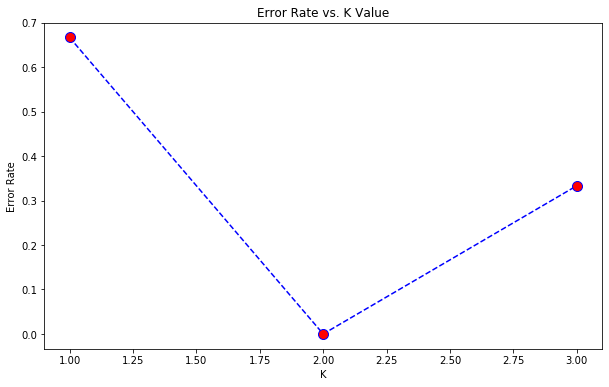

In [26]:
error_rate = []
for i in range(1, 4):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    pred_i = knn.predict(x_test)
    error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10, 6))
plt.plot(range(1, 4), error_rate, color = 'blue', linestyle = 'dashed', 
         marker = 'o',markerfacecolor = 'red', markersize = 10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-", min(error_rate),"at K =", error_rate.index(min(error_rate)) + 1)
plt.show()


In [42]:
svm_linear = SVC(kernel = 'linear')
svm_linear.fit(x_train, y_train)
svm_linear.score(x_test, y_test)
svm_linear_cv = cross_val_score(svm_linear, x_train, y_train, cv=2)
print(svm_linear_cv.mean())

0.375


In [43]:
svm_rbf = SVC(kernel = 'rbf')
svm_rbf.fit(x_train, y_train)
svm_rbf.score(x_test, y_test)
svm_rbf = cross_val_score(svm_rbf, x_train, y_train, cv=2)
print(svm_rbf.mean())

0.375
